In [11]:
cd ..

c:\Users\auror\New_VAES


In [12]:
import torch
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import itertools
import random
from src.useful_functions import *

In [13]:
#Architecture parameters and distributions of stimuli
N = 10
K = 10

#Training parameters
N_EPOCHS = 5000
N_SAMPLES = 500
lr = 1e-2
BATCH_SIZE = 500

EXPONENTIAL P(x)

In [14]:
#Distribution of stimuli and samples

p_x = torch.distributions.exponential.Exponential(0.5)

x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]

#Initialization of encoder and decoder 
enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted)
dec = MLPDecoder(N,200)
r = enc.sample(x_fine,100)
r_all = np.asarray(list(itertools.product([0, 1], repeat=N)))
r_all = torch.tensor(r_all).transpose(0,1).type(torch.float)

##functions for the losses
q = rate_ising(N)
loss = q(enc,x_fine)
dist = distortion_gaussian(x_fine,enc,dec)

Text(0, 0.5, 'Encoding')

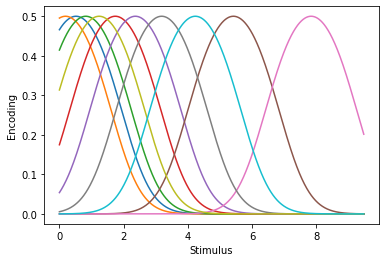

In [15]:
#Initialized encoder before training
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [16]:
#Traning on the entire set of parameters
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(enc.parameters(),q.parameters(), dec.parameters())
lr = 1e-3
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        rate = q(enc,x_)
        dist = distortion_gaussian(x_,enc,dec)
        loss = rate + dist
    
        opt.zero_grad()
        loss.backward()
        opt.step()
        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())

Text(0, 0.5, 'Encoding')

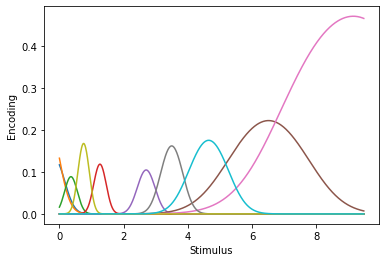

In [17]:
#Tuning curves with learned parameters
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

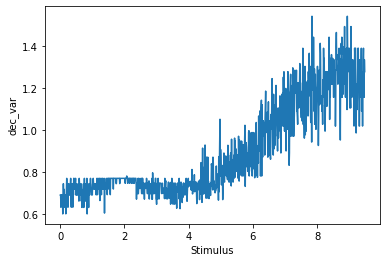

In [18]:
r= enc.sample(x_fine,15)
mu_dec,sigma2_dec = dec(r)
x_ext = dec.sample(r,10)

#variance of the decoder through the stimulus space
with torch.no_grad():
    plt.plot(x_fine,torch.sqrt(sigma2_dec.mean(dim=1)))
    plt.ylabel("dec_var")
    plt.xlabel("Stimulus")

Text(0.5, 0, 'Stimulus')

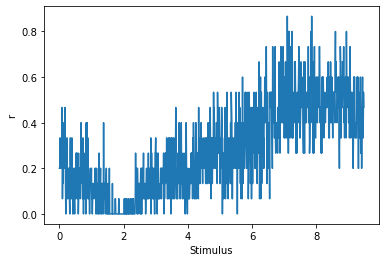

In [19]:
#Probability to be active. The x axis is the stimulus space
plt.plot(x_fine,r.sum(dim=2).mean(dim=1))
plt.ylabel("r")
plt.xlabel("Stimulus")

Text(0.5, 0, 'Stimulus')

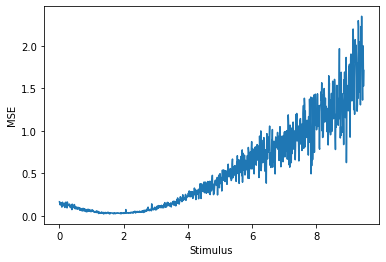

In [20]:
#Mean squared error
mseVec = ((x_ext - x_fine[None,:])**2).mean(dim=(0,2))
plt.plot(x_fine,mseVec.detach()/20)
plt.ylabel("MSE")
plt.xlabel("Stimulus")